# Kalman Filter

Linear-Gaussian state-space model filtering using the Kalman Filter.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from filters import KalmanFilter
from models import LinearGaussianModel, generate_data


1, Naive implementation of kalman filter in one-dimension 

In [3]:
# 1D Linear Gaussian Hidden Markov Model
# State x: hidden state (1D)
# Observation y: observation (1D)
# Linear: y = x + noise

# Model parameters
sigma_process = 0.5  # Process noise std
sigma_obs = 0.3      # Observation noise std

# State transition: x_{t+1} = F * x_t + w_t, w_t ~ N(0, Q)
F = np.array([[1.0]])  # 1x1: identity
B = np.array([[sigma_process]])  # Process noise matrix (Q = B @ B.T)

# Observation: y_t = H * x_t + v_t, v_t ~ N(0, R)
H = np.array([[1.1]])  # 1x1: observe state directly
D = np.array([[sigma_obs]])  # Observation noise matrix (R = D @ D.T)

# Initial state: x_0 ~ N(0, Sigma)
Sigma = np.array([[1.0]])  # Initial covariance

# Create model and generate data
random_state = np.random.default_rng(42)
model = LinearGaussianModel(F, B, H, D, mu_0=np.zeros(1), Sigma_0=Sigma, random_state=random_state)

T = 150
true_states, observations = generate_data(model, T, random_state)



In [4]:

kf = KalmanFilter(F, B, H, D, Sigma, use_joseph_form=False)
filtered_means, filtered_covs = kf.filter(observations)


In [5]:
errors = filtered_means - true_states  # Shape: (T, nx)

# Compute error norm per time step
error_norms = np.linalg.norm(errors, axis=1)  # Shape: (T,)

# Compute relative error per time step
true_norms = np.linalg.norm(true_states, axis=1)
relative_errors = np.where(true_norms > 1e-10, 
                           error_norms / true_norms, 
                           error_norms)


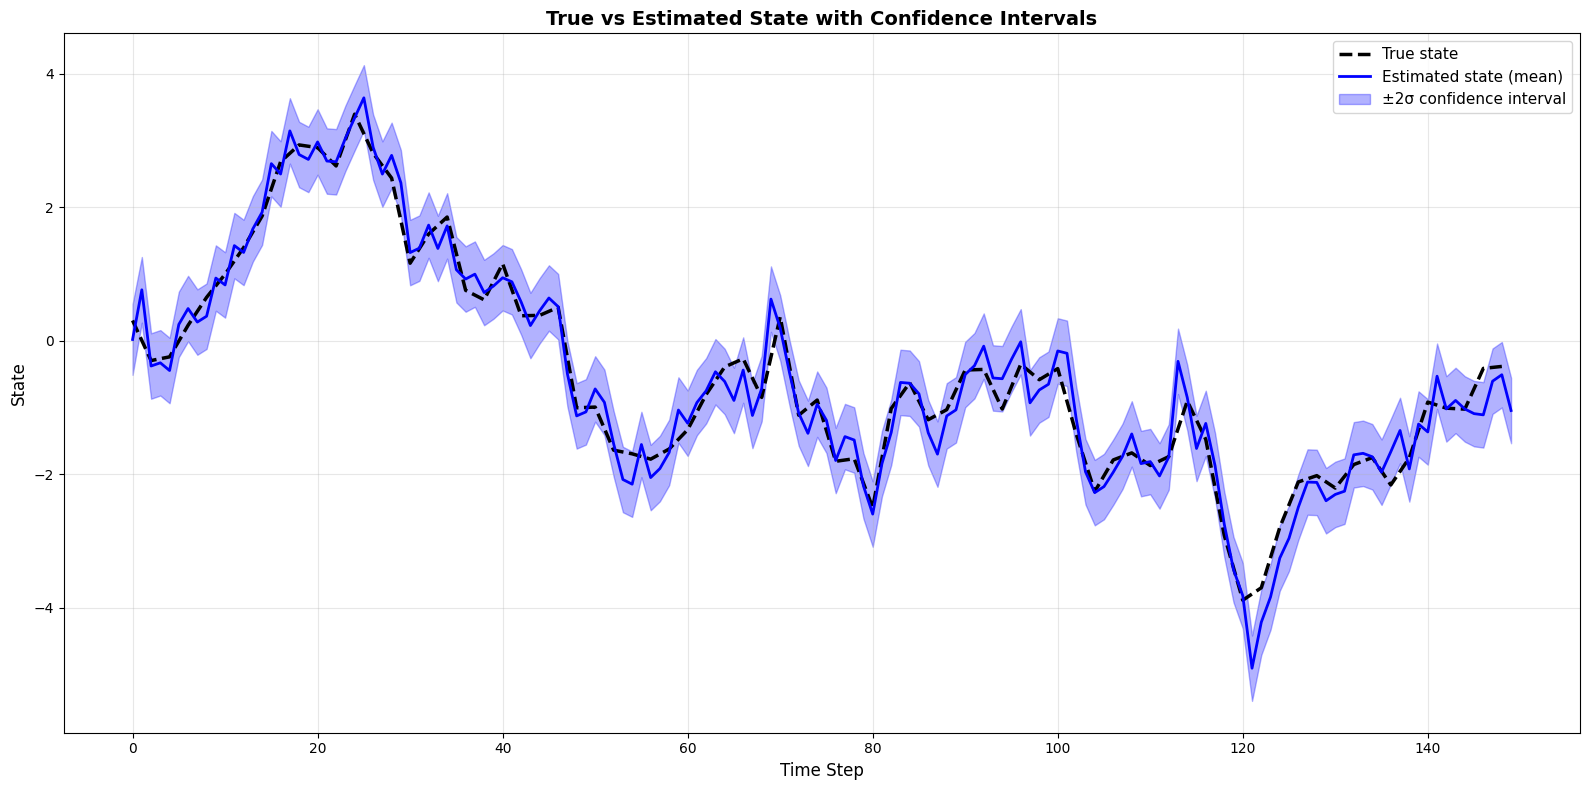

In [12]:
from matplotlib.lines import lineStyles


def plot_kf_1d():

    # Large plot: True vs Estimated with error bars (ribbons)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    time_steps = np.arange(T)

    # Extract standard deviation from filtered covariance
    if filtered_covs.shape[1] == 1:
        filtered_std = np.sqrt(filtered_covs[:, 0, 0])
    else:
        filtered_std = np.sqrt(np.trace(filtered_covs, axis1=1, axis2=2))

    # Plot true state
    ax.plot(time_steps[::2], true_states[::2, 0], 'k--', label='True state', linewidth=2.5)

    # Plot estimated state with error ribbons
    ax.plot(time_steps, filtered_means[:, 0], 'b-', label='Estimated state (mean)', linewidth=2)
    ax.fill_between(time_steps, 
                    filtered_means[:, 0] - 2*filtered_std, 
                    filtered_means[:, 0] + 2*filtered_std,
                    alpha=0.3, color='blue', label='±2σ confidence interval')

    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('State', fontsize=12)
    ax.set_title('True vs Estimated State with Confidence Intervals', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_kf_1d()

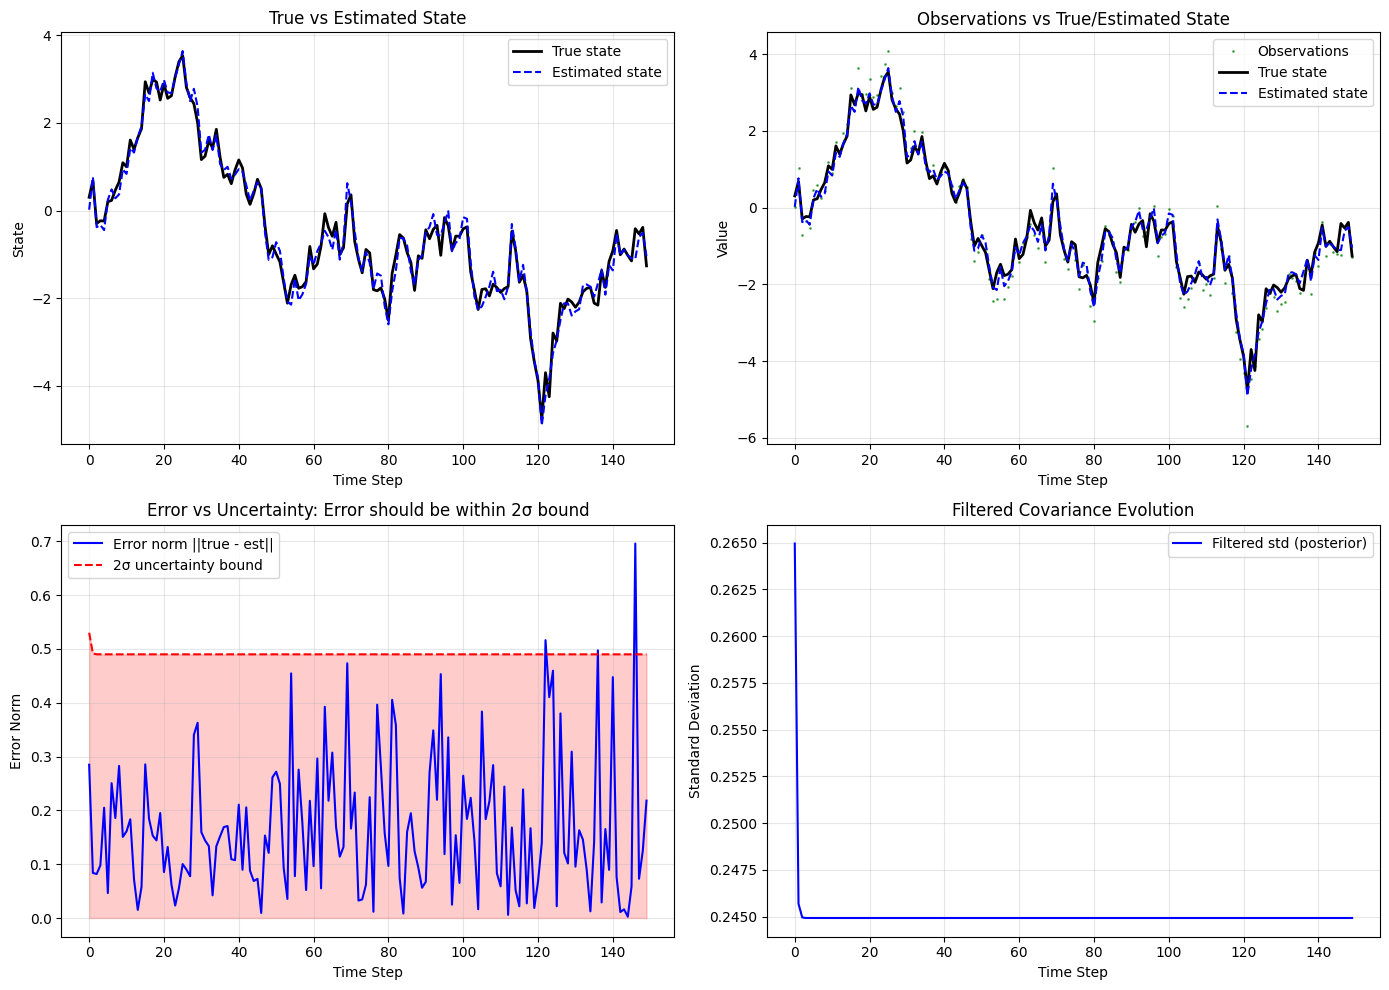

In [40]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
time_steps = np.arange(T)

# Plot 1: True vs Estimated
ax = axes[0, 0]
ax.plot(time_steps, true_states[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, filtered_means[:, 0], 'b--', label='Estimated state', linewidth=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel('State')
ax.set_title('True vs Estimated State')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Observations
ax = axes[0, 1]
ax.plot(time_steps, observations[:, 0], 'g.', label='Observations', markersize=2, alpha=0.6)
ax.plot(time_steps, true_states[:, 0], 'k-', label='True state', linewidth=2)
ax.plot(time_steps, filtered_means[:, 0], 'b--', label='Estimated state', linewidth=1.5)
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.set_title('Observations vs True/Estimated State')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Error norms with confidence bounds
# ax = axes[1, 0]
# # Compute uncertainty norm from covariance (trace of covariance matrix)
# uncertainty_norms = np.sqrt(np.trace(filtered_covs, axis1=1, axis2=2))  # Shape: (T,)
# ax.plot(time_steps, error_norms, 'b-', linewidth=1.5, label='Error norm')
# ax.fill_between(time_steps, np.zeros(T), 2*uncertainty_norms, alpha=0.3, color='blue', label='±2σ bound')
# ax.set_xlabel('Time Step')
# ax.set_ylabel('Error Norm')
# ax.set_title('Estimation Error Norms with Confidence Bounds')
# ax.legend()
# ax.grid(True, alpha=0.3)

ax = axes[1, 0]
uncertainty_norms = np.sqrt(np.trace(filtered_covs, axis1=1, axis2=2))
ax.plot(time_steps, error_norms, 'b-', linewidth=1.5, label='Error norm ||true - est||')
ax.plot(time_steps, 2*uncertainty_norms, 'r--', linewidth=1.5, label='2σ uncertainty bound')
ax.fill_between(time_steps, np.zeros(T), 2*uncertainty_norms, alpha=0.2, color='red')
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('Error vs Uncertainty: Error should be within 2σ bound')
ax.legend()
ax.grid(True, alpha=0.3)

# # Plot 4: Innovations
# ax = axes[1, 1]
# history = kf.get_history()
# innovations = np.array(history['innovations'])
# ax.plot(time_steps, innovations[:, 0], 'b-', linewidth=1.5, label='Innovation', alpha=0.7)
# ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
# ax.set_xlabel('Time Step')
# ax.set_ylabel('Innovation')
# ax.set_title('Innovation Sequence (should be white noise)')
# ax.legend()
# ax.grid(True, alpha=0.3)

# Plot 4: Filtered Covariance (posterior/updated covariance)
ax = axes[1, 1]
# Extract standard deviation from filtered covariance
if filtered_covs.shape[1] == 1:
    filtered_std = np.sqrt(filtered_covs[:, 0, 0])
else:
    filtered_std = np.sqrt(np.trace(filtered_covs, axis1=1, axis2=2))

ax.plot(time_steps, filtered_std, 'b-', linewidth=1.5, label='Filtered std (posterior)')
ax.set_xlabel('Time Step')
ax.set_ylabel('Standard Deviation')
ax.set_title('Filtered Covariance Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

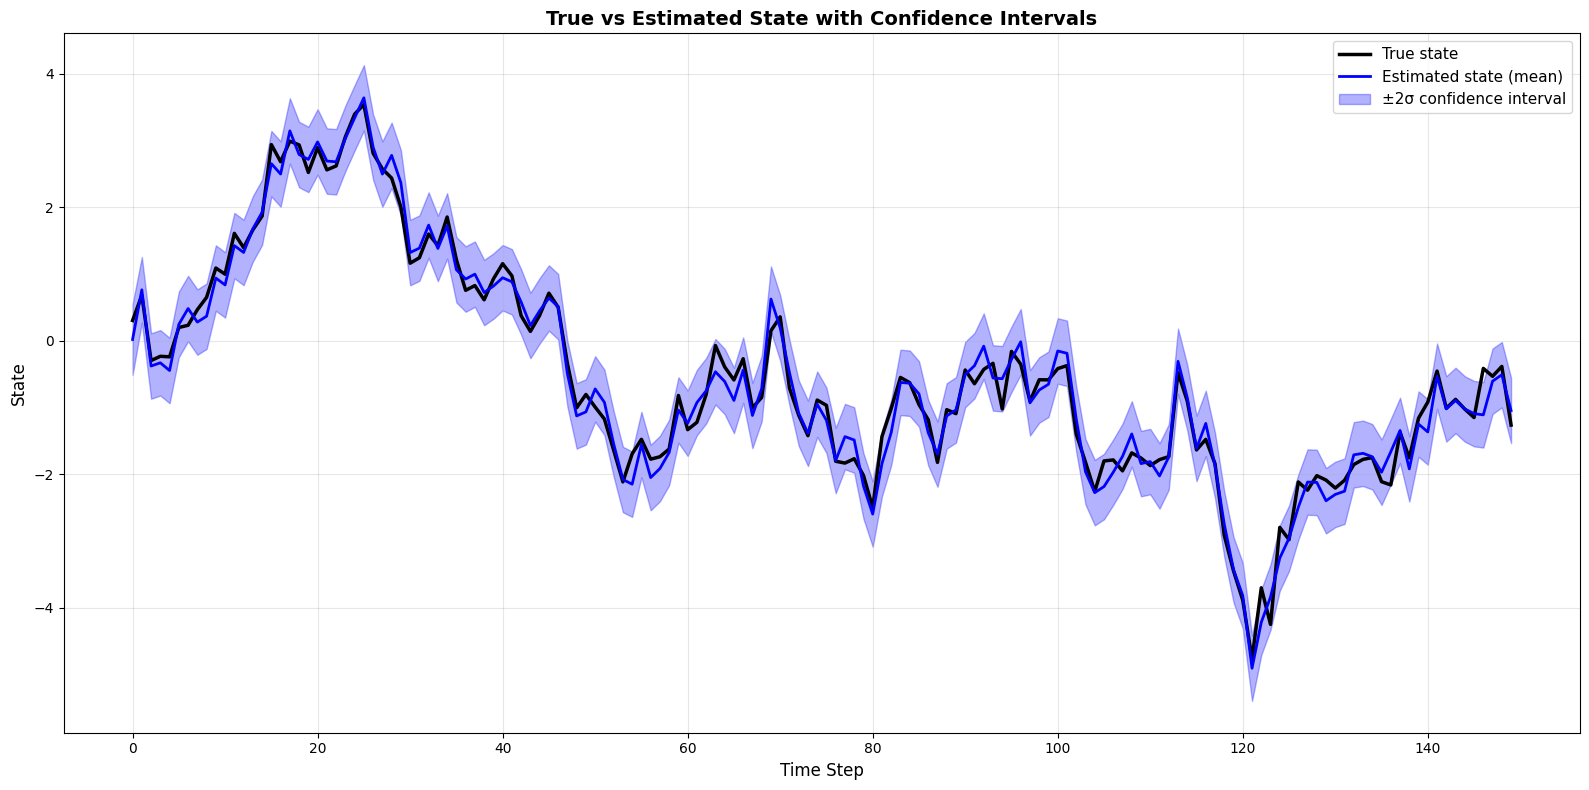

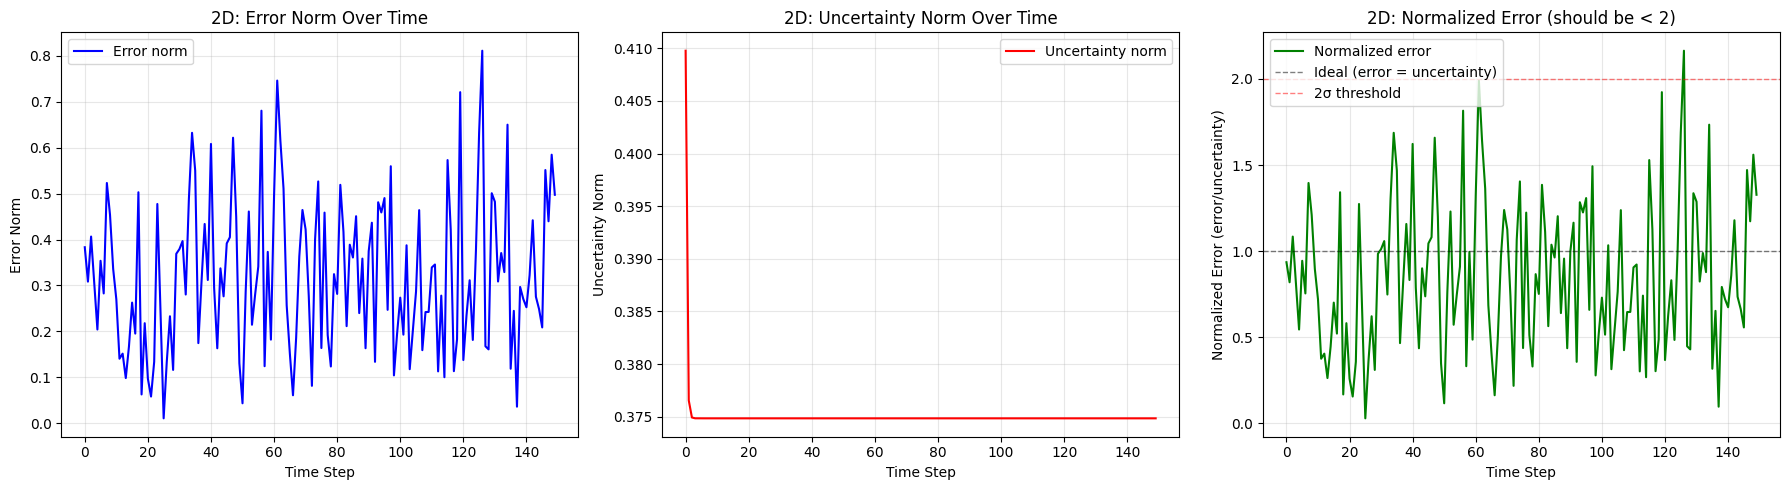

2D - Mean normalized error: 0.8532
2D - Max normalized error: 2.1642


In [42]:
# 2D Linear Gaussian Model
# State: [x1, x2] (2D)
# Observation: [y1, y2] (2D)

sigma_process = 0.5
sigma_obs = 0.3

# State transition: x_{t+1} = F * x_t + w_t
F = np.eye(2)  # 2x2 identity
B = sigma_process * np.eye(2)

# Observation: y_t = H * x_t + v_t
H = np.eye(2)  # 2x2 identity (observe state directly)
D = sigma_obs * np.eye(2)

# Initial state
Sigma = np.eye(2)

# Create model and generate data
random_state = np.random.default_rng(42)
model_2d = LinearGaussianModel(F, B, H, D, mu_0=np.zeros(2), Sigma_0=Sigma, random_state=random_state)
T = 150
true_states_2d, observations_2d = generate_data(model_2d, T, random_state)

# Run Kalman filter
kf_2d = KalmanFilter(F, B, H, D, Sigma, use_joseph_form=False)
filtered_means_2d, filtered_covs_2d = kf_2d.filter(observations_2d)

# Compute errors
errors_2d = filtered_means_2d - true_states_2d
error_norms_2d = np.linalg.norm(errors_2d, axis=1)
uncertainty_norms_2d = np.sqrt(np.trace(filtered_covs_2d, axis1=1, axis2=2))
normalized_errors_2d = error_norms_2d / uncertainty_norms_2d

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
time_steps = np.arange(T)

# Plot 1: Error norm
ax = axes[0]
ax.plot(time_steps, error_norms_2d, 'b-', linewidth=1.5, label='Error norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('2D: Error Norm Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Uncertainty norm
ax = axes[1]
ax.plot(time_steps, uncertainty_norms_2d, 'r-', linewidth=1.5, label='Uncertainty norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('2D: Uncertainty Norm Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Normalized error
ax = axes[2]
ax.plot(time_steps, normalized_errors_2d, 'g-', linewidth=1.5, label='Normalized error')
ax.axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Ideal (error = uncertainty)')
ax.axhline(y=2.0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='2σ threshold')
ax.set_xlabel('Time Step')
ax.set_ylabel('Normalized Error (error/uncertainty)')
ax.set_title('2D: Normalized Error (should be < 2)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"2D - Mean normalized error: {np.mean(normalized_errors_2d):.4f}")
print(f"2D - Max normalized error: {np.max(normalized_errors_2d):.4f}")

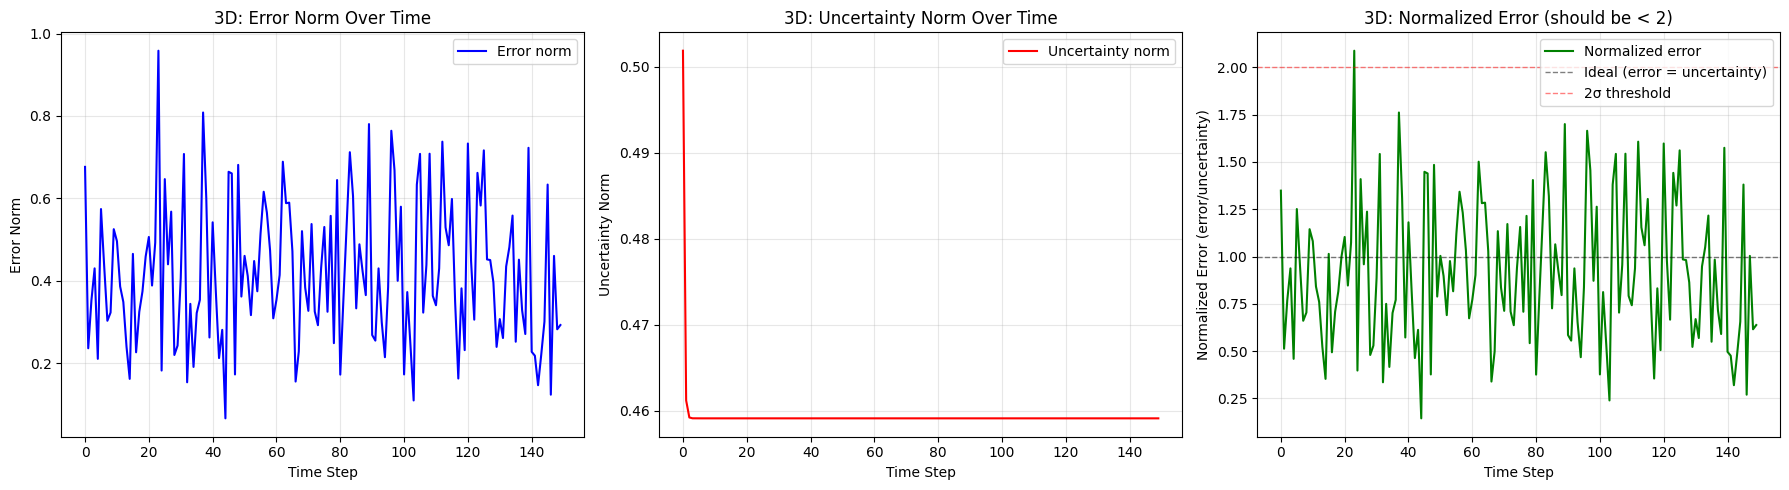

3D - Mean normalized error: 0.9114
3D - Max normalized error: 2.0873


In [43]:
# 3D Linear Gaussian Model
# State: [x1, x2, x3] (3D)
# Observation: [y1, y2, y3] (3D)

sigma_process = 0.5
sigma_obs = 0.3

# State transition: x_{t+1} = F * x_t + w_t
F = np.eye(3)  # 3x3 identity
B = sigma_process * np.eye(3)

# Observation: y_t = H * x_t + v_t
H = np.eye(3)  # 3x3 identity
D = sigma_obs * np.eye(3)

# Initial state
Sigma = np.eye(3)

# Create model and generate data
random_state = np.random.default_rng(42)
model_3d = LinearGaussianModel(F, B, H, D, mu_0=np.zeros(3), Sigma_0=Sigma, random_state=random_state)
true_states_3d, observations_3d = generate_data(model_3d, T, random_state)

# Run Kalman filter
kf_3d = KalmanFilter(F, B, H, D, Sigma, use_joseph_form=False)
filtered_means_3d, filtered_covs_3d = kf_3d.filter(observations_3d)

# Compute errors
errors_3d = filtered_means_3d - true_states_3d
error_norms_3d = np.linalg.norm(errors_3d, axis=1)
uncertainty_norms_3d = np.sqrt(np.trace(filtered_covs_3d, axis1=1, axis2=2))
normalized_errors_3d = error_norms_3d / uncertainty_norms_3d

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
time_steps = np.arange(T)

# Plot 1: Error norm
ax = axes[0]
ax.plot(time_steps, error_norms_3d, 'b-', linewidth=1.5, label='Error norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Error Norm')
ax.set_title('3D: Error Norm Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Uncertainty norm
ax = axes[1]
ax.plot(time_steps, uncertainty_norms_3d, 'r-', linewidth=1.5, label='Uncertainty norm')
ax.set_xlabel('Time Step')
ax.set_ylabel('Uncertainty Norm')
ax.set_title('3D: Uncertainty Norm Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Normalized error
ax = axes[2]
ax.plot(time_steps, normalized_errors_3d, 'g-', linewidth=1.5, label='Normalized error')
ax.axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Ideal (error = uncertainty)')
ax.axhline(y=2.0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='2σ threshold')
ax.set_xlabel('Time Step')
ax.set_ylabel('Normalized Error (error/uncertainty)')
ax.set_title('3D: Normalized Error (should be < 2)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"3D - Mean normalized error: {np.mean(normalized_errors_3d):.4f}")
print(f"3D - Max normalized error: {np.max(normalized_errors_3d):.4f}")

In [ ]:
class Kalmanexperiments:
    """
    Class for running Kalman filter experiments with standardized plotting methods.
    
    Inputs:
        F: State transition matrix (nx, nx)
        B: Process noise matrix (nx, nv)
        H: Observation matrix (ny, nx)
        D: Observation noise matrix (ny, nw)
        Sigma: Initial covariance matrix (nx, nx)
        mu_0: Initial state mean (nx,), optional (default: zeros)
        random_state: numpy random generator, optional
        T: Number of time steps
        joseph_form: Whether to use Joseph form for covariance update (default: False)
    """
    
    def __init__(self, F, B, H, D, Sigma, mu_0=None, random_state=None, T=150, joseph_form=False):
        self.F = F
        self.B = B
        self.H = H
        self.D = D
        self.Sigma = Sigma
        self.mu_0 = mu_0 if mu_0 is not None else np.zeros(F.shape[0])
        self.random_state = random_state if random_state is not None else np.random.default_rng(42)
        self.T = T
        self.joseph_form = joseph_form
        
        # State dimension
        self.nx = F.shape[0]
        
        # Initialize flags to track what has been computed
        self._data_generated = False
        self._filter_run = False
        self._errors_computed = False
        
        # Initialize storage variables
        self.model = None
        self.true_states = None
        self.observations = None
        self.kf = None
        self.filtered_means = None
        self.filtered_covs = None
        self.errors = None
        self.error_norms = None
        self.uncertainty_norms = None
        self.relative_errors = None
    
    def generate_data(self):
        """Generate true states and observations from the model."""
        from models import LinearGaussianModel, generate_data
        
        # Create model
        self.model = LinearGaussianModel(
            self.F, self.B, self.H, self.D, 
            mu_0=self.mu_0, 
            Sigma_0=self.Sigma, 
            random_state=self.random_state
        )
        
        # Generate data
        self.true_states, self.observations = generate_data(self.model, self.T, self.random_state)
        self._data_generated = True
    
    def run_filter(self):
        """Run the Kalman filter on the observations."""
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data() before run_filter().")
        
        from filters import KalmanFilter
        self.kf = KalmanFilter(self.F, self.B, self.H, self.D, self.Sigma, use_joseph_form=self.joseph_form)
        self.filtered_means, self.filtered_covs = self.kf.filter(self.observations)
        self._filter_run = True
    
    def compute_errors(self):
        """Compute errors, error norms, uncertainty norms, and relative errors."""
        if not self._filter_run:
            raise ValueError("Filter must be run first. Call run_filter() before compute_errors().")
        
        # Compute errors
        self.errors = self.filtered_means - self.true_states
        self.error_norms = np.linalg.norm(self.errors, axis=1)
        self.uncertainty_norms = np.sqrt(np.trace(self.filtered_covs, axis1=1, axis2=2))
        
        # Relative error
        true_norms = np.linalg.norm(self.true_states, axis=1)
        self.relative_errors = np.where(
            true_norms > 1e-10, 
            self.error_norms / true_norms, 
            self.error_norms
        )
        self._errors_computed = True
    
    def get_true_states(self):
        """Return true states."""
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data().")
        return self.true_states
    
    def get_observations(self):
        """Return observations."""
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data().")
        return self.observations
    
    def get_absolute_error(self):
        """Return absolute error norms."""
        if not self._errors_computed:
            raise ValueError("Errors must be computed first. Call compute_errors().")
        return self.error_norms
    
    def get_relative_error(self):
        """Return relative errors."""
        if not self._errors_computed:
            raise ValueError("Errors must be computed first. Call compute_errors().")
        return self.relative_errors
    
    def plot_true_vs_estimated_with_confidence(self):
        """
        Plot 1: True vs Estimated states with confidence level (error bar version).
        Works only for 1D data.
        """
        if not self._filter_run:
            raise ValueError("Filter must be run first. Call run_filter().")
        if self.nx != 1:
            raise ValueError("Plot 1 only works for 1D data (state_dim = 1)")
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        time_steps = np.arange(self.T)
        
        # Extract standard deviation from filtered covariance
        filtered_std = np.sqrt(self.filtered_covs[:, 0, 0])
        
        # Plot true state
        ax.plot(time_steps, self.true_states[:, 0], 'k--', label='True state', linewidth=2.5)
        
        # Plot estimated state with error ribbons
        ax.plot(time_steps, self.filtered_means[:, 0], 'b-', label='Estimated state (mean)', linewidth=2)
        ax.fill_between(
            time_steps, 
            self.filtered_means[:, 0] - 2*filtered_std, 
            self.filtered_means[:, 0] + 2*filtered_std,
            alpha=0.3, color='blue', label='±2σ confidence interval'
        )
        
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('State', fontsize=12)
        ax.set_title('True vs Estimated State with Confidence Intervals', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_true_vs_estimated_with_observations(self):
        """
        Plot 2: True vs Estimated states with observations.
        Works only for 1D data.
        """
        if not self._filter_run:
            raise ValueError("Filter must be run first. Call run_filter().")
        if self.nx != 1:
            raise ValueError("Plot 2 only works for 1D data (state_dim = 1)")
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 6))
        time_steps = np.arange(self.T)
        
        ax.plot(time_steps, self.observations[:, 0], 'g.', label='Observations', markersize=2, alpha=0.6)
        ax.plot(time_steps, self.true_states[:, 0], 'k-', label='True state', linewidth=2)
        ax.plot(time_steps, self.filtered_means[:, 0], 'b--', label='Estimated state', linewidth=1.5)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.set_title('Observations vs True/Estimated State')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_absolute_error_with_2sigma(self):
        """
        Plot 3: Absolute error with 2 sigma bound.
        Works for any dimension.
        """
        if not self._errors_computed:
            raise ValueError("Errors must be computed first. Call compute_errors().")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        time_steps = np.arange(self.T)
        
        ax.plot(time_steps, self.error_norms, 'b-', linewidth=1.5, label='Error norm ||true - est||')
        ax.plot(time_steps, 2*self.uncertainty_norms, 'r--', linewidth=1.5, label='2σ uncertainty bound')
        ax.fill_between(time_steps, np.zeros(self.T), 2*self.uncertainty_norms, alpha=0.2, color='red')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Error Norm')
        ax.set_title('Error vs Uncertainty: Error should be within 2σ bound')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    

In [23]:
sigma_process1 = 0.5  # Process noise std
sigma_obs1 = 0.3      # Observation noise std
Sigma1 = np.array([[1.0]])
# State transition: x_{t+1} = F * x_t + w_t, w_t ~ N(0, Q)
F1 = np.array([[1.0]])  # 1x1: identity
B1 = np.array([[sigma_process1]])  # Process noise matrix (Q = B @ B.T)

# Observation: y_t = H * x_t + v_t, v_t ~ N(0, R)
H1 = np.array([[1.1]])  # 1x1: observe state directly
D1 = np.array([[sigma_obs1]])

# Create experiment instance
exp_1 = Kalmanexperiments(F1, B1, H1, D1, Sigma=Sigma1, T=150, joseph_form=False)

# Generate data, run filter, and compute errors
exp_1.generate_data()
exp_1.run_filter()
exp_1.compute_errors()

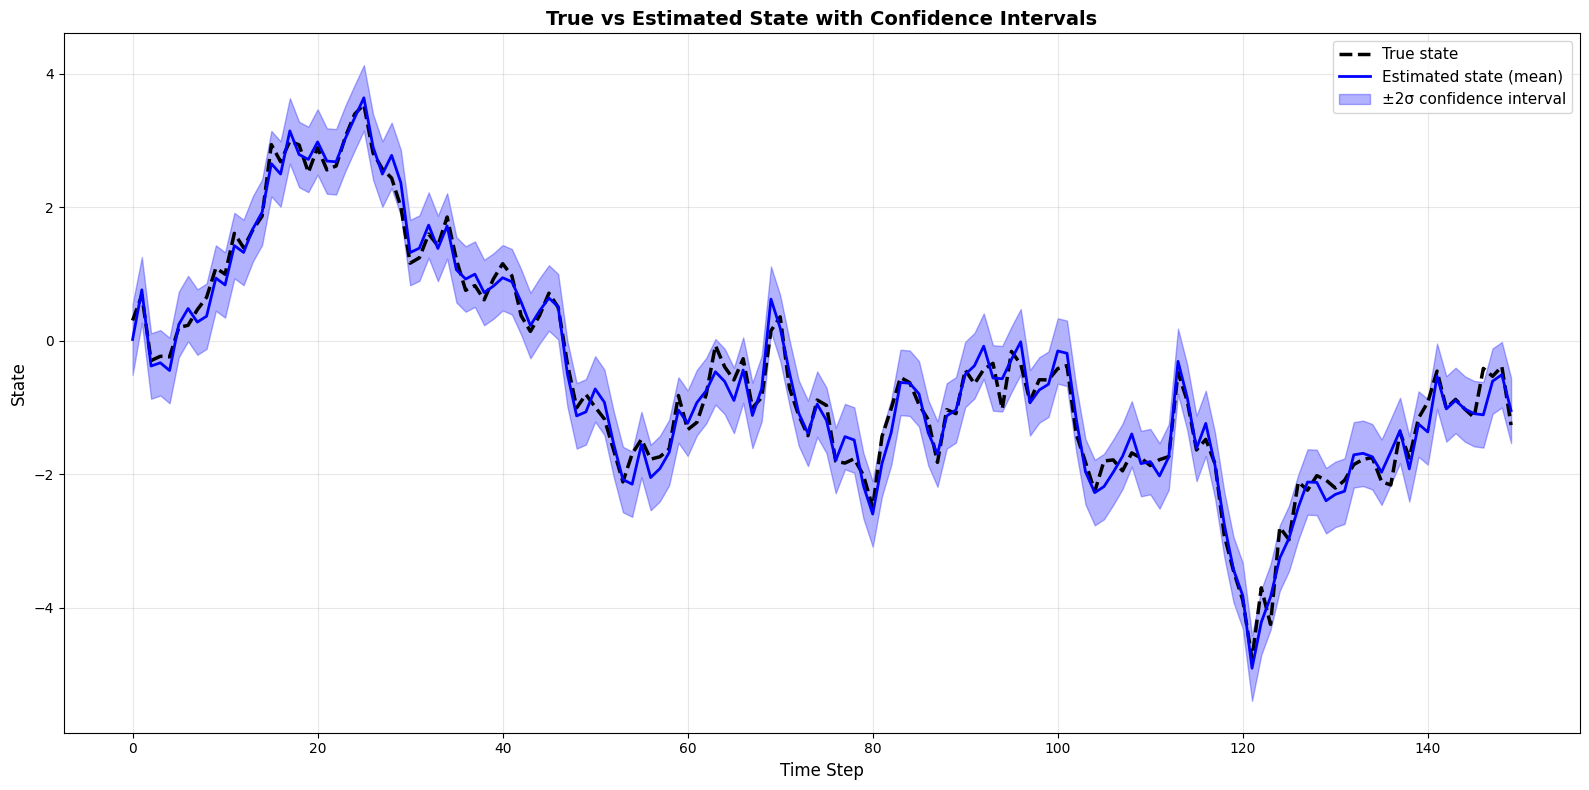

In [17]:
exp_1.plot_true_vs_estimated_with_confidence()

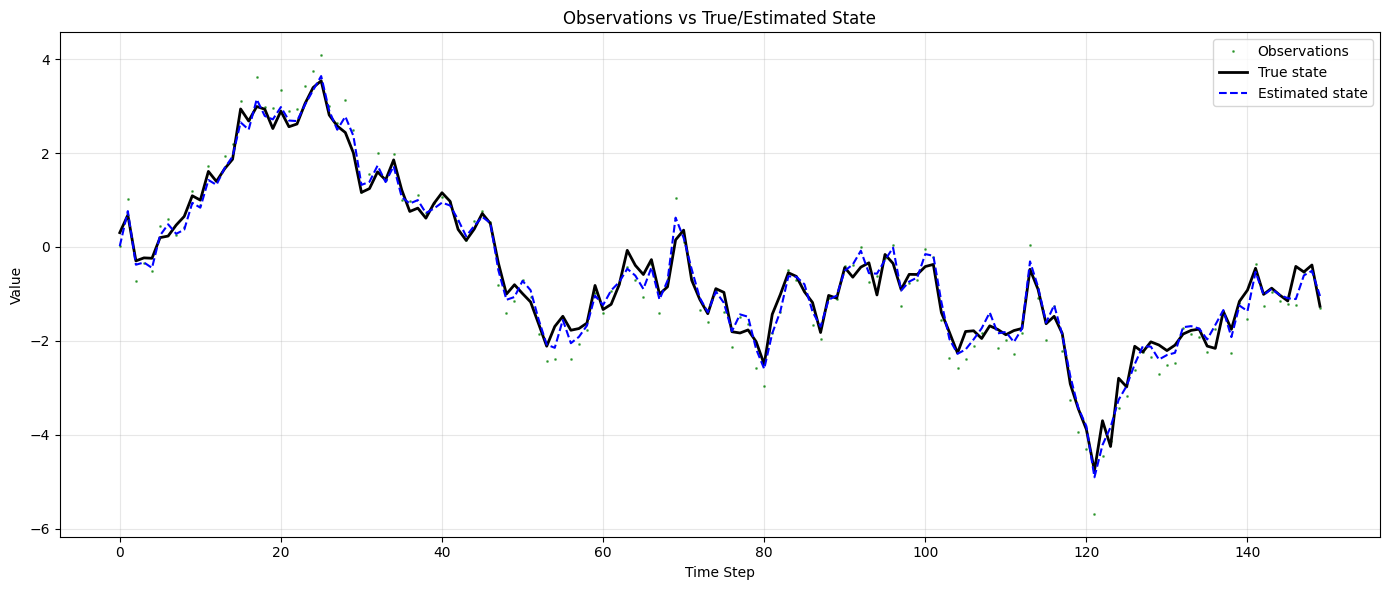

In [19]:
exp_1.plot_true_vs_estimated_with_observations()

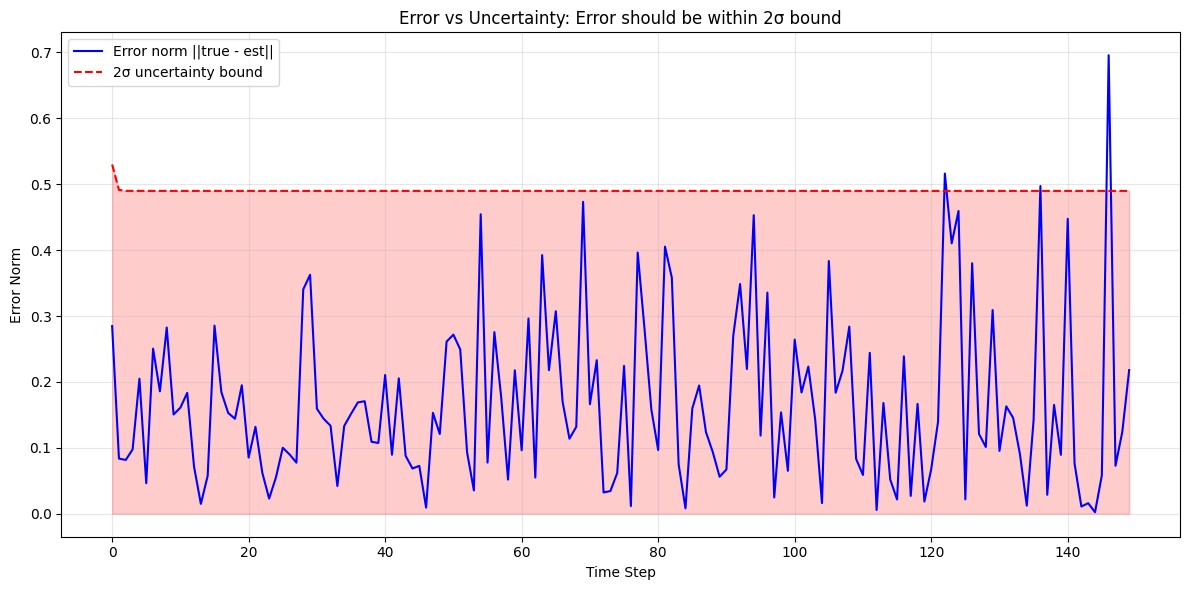

In [24]:
exp_1.plot_absolute_error_with_2sigma()